# Credit Card Fraud Transaction Detection

## Introduction

In today’s digital age, where financial transactions and data exchanges occur at an unprecedented
scale, the risk of fraudulent activities has become a significant concern for businesses, consumers,
and governments alike. Fraud, whether in the form of unauthorized transactions, identity theft, or
data manipulation, poses a serious threat to financial stability, operational efficiency, and trust in
digital systems. As organizations increasingly rely on online platforms and automated processes,
the need for robust and intelligent fraud detection mechanisms has never been more critical.

Through this project, we seek to address the growing challenges posed by fraud, protect financial
assets, enhance customer trust, and contribute to the development of secure and resilient digital
ecosystems. By combining innovative technology with a deep understanding of fraud dynamics, this
initiative aspires to set a new standard in fraud detection and prevention.



## 1. Import Data

In [1]:
import json
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score

In [2]:
pd.set_option("display.max_columns", None)  # Show all columns

In [3]:
df = pd.read_excel('/Users/azhang/Downloads/transactions.xlsx')
rename_dict = {
    "accountNumber": "accountNumber",
    "customerId": "customerId",
    "creditLimit": "creditLimit",
    "availableMoney": "availableBalance",
    "transactionDateTime": "transactionTime",
    "transactionAmount": "transactionAmount",
    "merchantName": "merchantName",
    "acqCountry": "acquiringCountry",
    "merchantCountryCode": "merchantCountry",
    "posEntryMode": "posEntryMode",
    "posConditionCode": "posConditionCode",
    "merchantCategoryCode": "merchantCategory",
    "currentExpDate": "cardExpiryDate",
    "accountOpenDate": "accountOpenDate",
    "dateOfLastAddressChange": "lastAddressChangeDate",
    "cardCVV": "cardCvv",
    "enteredCVV": "cvvEntered",
    "cardLast4Digits": "cardLast4",
    "transactionType": "transactionType",
    "echoBuffer": "echoBuffer",
    "currentBalance": "currentBalance",
    "merchantCity": "merchantCity",
    "merchantState": "merchantState",
    "merchantZip": "merchantZip",
    "cardPresent": "cardPresent",
    "posOnPremises": "posOnPremises",
    "recurringAuthInd": "recurringAuth",
    "expirationDateKeyInMatch": "expiryKeyMatch",
    "isFraud": "isFraud"
}
df.rename(columns=rename_dict, inplace=True)

##  Data Hightlight

The transaction dataset consisted of 786,363 records and 29 features. Among these, 6 features were entirely missing: 'echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', and 'recurringAuthInd'. We deleted these columns for the following analysis since these column had no information.

5 features had partial missing values: 'acquiringCountry', 'merchantCountry', 'posEntryMode', 'posConditionCode', and 'transactionType'. However, the proportion of missing values in these features was negligible relative to the total sample size.

In [4]:
df.shape

(786363, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   accountNumber          786363 non-null  int64         
 1   customerId             786363 non-null  int64         
 2   creditLimit            786363 non-null  int64         
 3   availableBalance       786363 non-null  float64       
 4   transactionTime        786363 non-null  object        
 5   transactionAmount      786363 non-null  float64       
 6   merchantName           786363 non-null  object        
 7   acquiringCountry       781801 non-null  object        
 8   merchantCountry        785639 non-null  object        
 9   posEntryMode           782309 non-null  float64       
 10  posConditionCode       785954 non-null  float64       
 11  merchantCategory       786363 non-null  object        
 12  cardExpiryDate         786363 non-null  date

In [6]:
df.drop(['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuth'], axis = 1, inplace = True)

In [7]:
# some columns had empty input, replace by nan
df.replace('', np.nan, inplace=True)

In [8]:
df.isnull().sum()[df.isnull().sum() > 0]

acquiringCountry    4562
merchantCountry      724
posEntryMode        4054
posConditionCode     409
transactionType      698
dtype: int64

In [9]:
# get numeric columns
numeric_columns = ['creditLimit','availableBalance','transactionAmount','currentBalance']
# get date columns
date_columns = ['transactionTime','cardExpiryDate', 'accountOpenDate', 'lastAddressChangeDate']
## get catrgorical variables
cat_columns = []
for col in df.columns:
    if col not in date_columns and col not in date_columns:
        cat_columns.append(col)

### Categorical & Datetime Feature

The dataset contained 2016 transaction history for 5,000 users, mostly labeled as PURCHASE. The company served a diverse mix of long-term loyal customers and newer users, as evidenced by the wide range of 'accountOpenDate' values, spanning from 1989 to 2015.

Most users made transactions with Uber and for online shopping (not necessarily related to Uber) within the United States. The differences in unique values for 'enteredCVV' and 'merchantCategoryCode' suggest potential typos during transaction entries.

In [10]:
df[cat_columns].describe(include='object')

,merchantName,acquiringCountry,merchantCountry,merchantCategory,transactionType
count,786363,781801,785639,786363,785665
unique,2490,4,4,19,3
top,Uber,US,US,online_retail,PURCHASE
freq,25613,774709,778511,202156,745193


In [11]:
# Initialize results
results = {'Column': [], 'Min Date': [], 'Max Date': [], 'Unique Dates Count': []}

for col in date_columns:
    # Convert to datetime 
    df[col] = pd.to_datetime(df[col])
    
    # Calculate min, max, and unique values
    min_date = df[col].min()
    max_date = df[col].max()
    unique_dates_count = df[col].nunique() 
    
    # Append results
    results['Column'].append(col)
    results['Min Date'].append(min_date)
    results['Max Date'].append(max_date)
    results['Unique Dates Count'].append(unique_dates_count)

results_df = pd.DataFrame(results)
results_df

,Column,Min Date,Max Date,Unique Dates Count
0,transactionTime,2016-01-01 00:01:02,2016-12-30 23:59:45,776637
1,cardExpiryDate,2019-12-01 00:00:00,2033-08-01 00:00:00,165
2,accountOpenDate,1989-08-22 00:00:00,2015-12-31 00:00:00,1820
3,lastAddressChangeDate,1989-08-22 00:00:00,2016-12-30 00:00:00,2184


### Numeric Feature

The dataset shows a wide range of values for credit limits, available money, and current balances, indicating diverse financial behaviors among users.

The negative available money suggests some users may overdraft.

Transaction amounts are relatively small, with most transactions being under $200. 

In [12]:
df[numeric_columns].describe()

,creditLimit,availableBalance,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


### Boolean

Very few transactions were fraud transactions and had expiration date key in match.

In [13]:
df['isFraud'].value_counts()

isFraud
False    773946
True      12417
Name: count, dtype: int64

In [14]:
df['expiryKeyMatch'].value_counts()

expiryKeyMatch
False    785320
True       1043
Name: count, dtype: int64

## Modeling

###  Understand the Raw Dataset

In [15]:
round(df['isFraud'].value_counts(normalize=True),3)

isFraud
False    0.984
True     0.016
Name: proportion, dtype: float64

We derived features based on the original data for more convenient data exploration and better insights.

In [16]:
#acount related
df['accountOpenYear'] = pd.to_datetime(df['accountOpenDate']).dt.year.astype(int)
df['yearOfLastAddressChange'] = pd.to_datetime(df['lastAddressChangeDate']).dt.year.astype(int)

#is transactions outside account open country?
df['OutsideAccountCountry'] = (df['merchantCountry'] == df['acquiringCountry'])
df['OutsideAccountCountry'] = df['OutsideAccountCountry'].apply(lambda x: 'Same Account Open Country' if x else 'Outside Account Open Country')

#transaction month and hour
df['transactionHour'] = pd.to_datetime(df['transactionTime']).dt.hour
df['transactionMonth'] = pd.to_datetime(df['transactionTime']).dt.month
df['Year-Month'] = pd.to_datetime(df['transactionTime']).dt.strftime('%Y-%m')

# Card exp year
df['currentExpYear'] = pd.to_datetime(df['cardExpiryDate']).dt.year

#is tpo
df['isTypo'] = df['cardCvv'] == df['cvvEntered']


In [17]:
#total transactions in a year per account
grouped = df.groupby(['accountNumber', 'customerId'])
result_counts = grouped['transactionType'].value_counts().unstack(fill_value=0)
result_counts['YearlyTransactions'] = result_counts['PURCHASE'] - result_counts['REVERSAL']
result_counts = result_counts.reset_index()

In [18]:
#total transactions in a month
grouped_m = df.groupby(['accountNumber', 'customerId','Year-Month'])
result_counts_m = grouped_m['transactionType'].value_counts().unstack(fill_value=0)
result_counts_m['MonthlyTransactions'] = result_counts_m['PURCHASE'] - result_counts_m['REVERSAL']
result_counts_m = result_counts_m.reset_index()

In [19]:
df = pd.merge(df,result_counts,'left',['accountNumber', 'customerId'])
df = pd.merge(df,result_counts_m,'left',['accountNumber', 'customerId','Year-Month'])
df.drop(['ADDRESS_VERIFICATION_x','PURCHASE_x','REVERSAL_x','ADDRESS_VERIFICATION_y','PURCHASE_y','REVERSAL_y'],axis = 1,inplace = True)

#### Card Attributes

US card holders had the lowest fraud rate and Canada users had the highest fraud rate. Fraudulent and non-fraudulent transactions have similar account open years. 

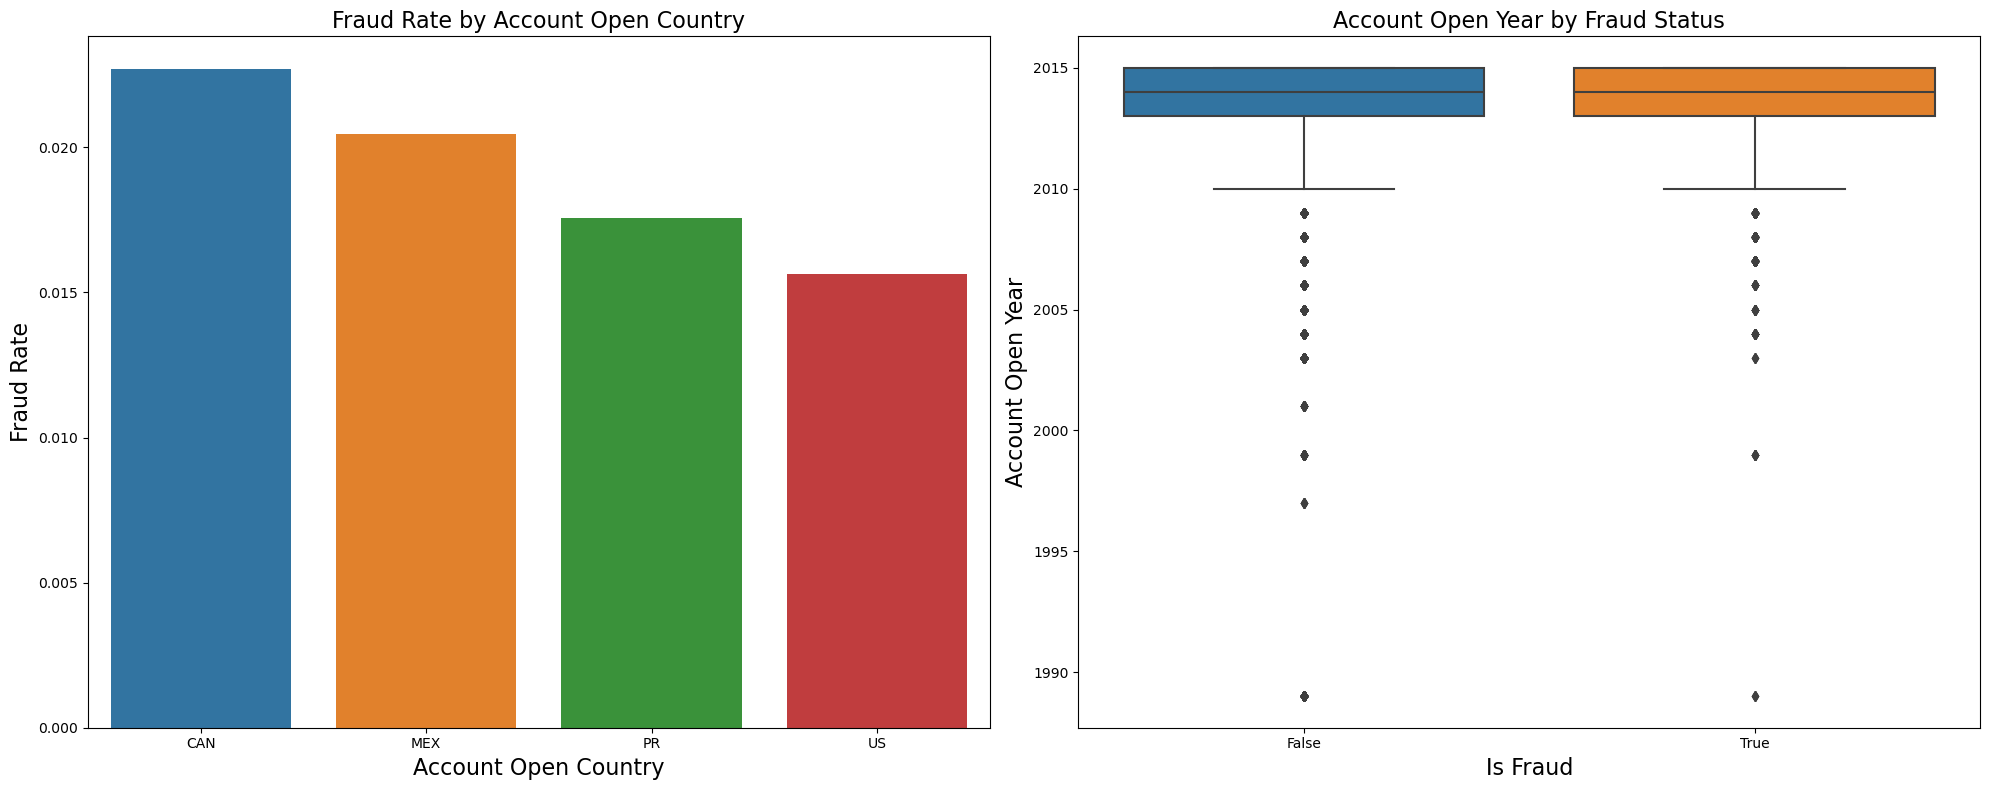

In [20]:
fig,axp = plt.subplots(1,2, figsize=[20,8])

# account country vs fraud
avg_fraud_country = df.groupby('acquiringCountry')['isFraud'].mean().reset_index()
sns.barplot(x = 'acquiringCountry', y = 'isFraud', data = avg_fraud_country,ax = axp[0])
axp[0].set_title('Fraud Rate by Account Open Country', fontsize = 16)
axp[0].set_xlabel('Account Open Country', fontsize = 16)
axp[0].set_ylabel('Fraud Rate', fontsize = 16)

# account open year vs fraud
sns.boxplot(x='isFraud', y='accountOpenYear', data = df, ax = axp[1])
axp[1].set_title('Account Open Year by Fraud Status', fontsize = 16)
axp[1].set_xlabel('Is Fraud', fontsize = 16)
axp[1].set_ylabel('Account Open Year', fontsize = 16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Transaction Attributes

Transactions outside the account's open country had a higher fraud risk and Airline, rideshare and online purchases were the most fraud-prone categories. Fraudulent transactions were often higher in amount but not strongly linked to available funds. Card-present transactions were less risky and fraud was most frequent in January, February, and between 11 AM and 1 PM.

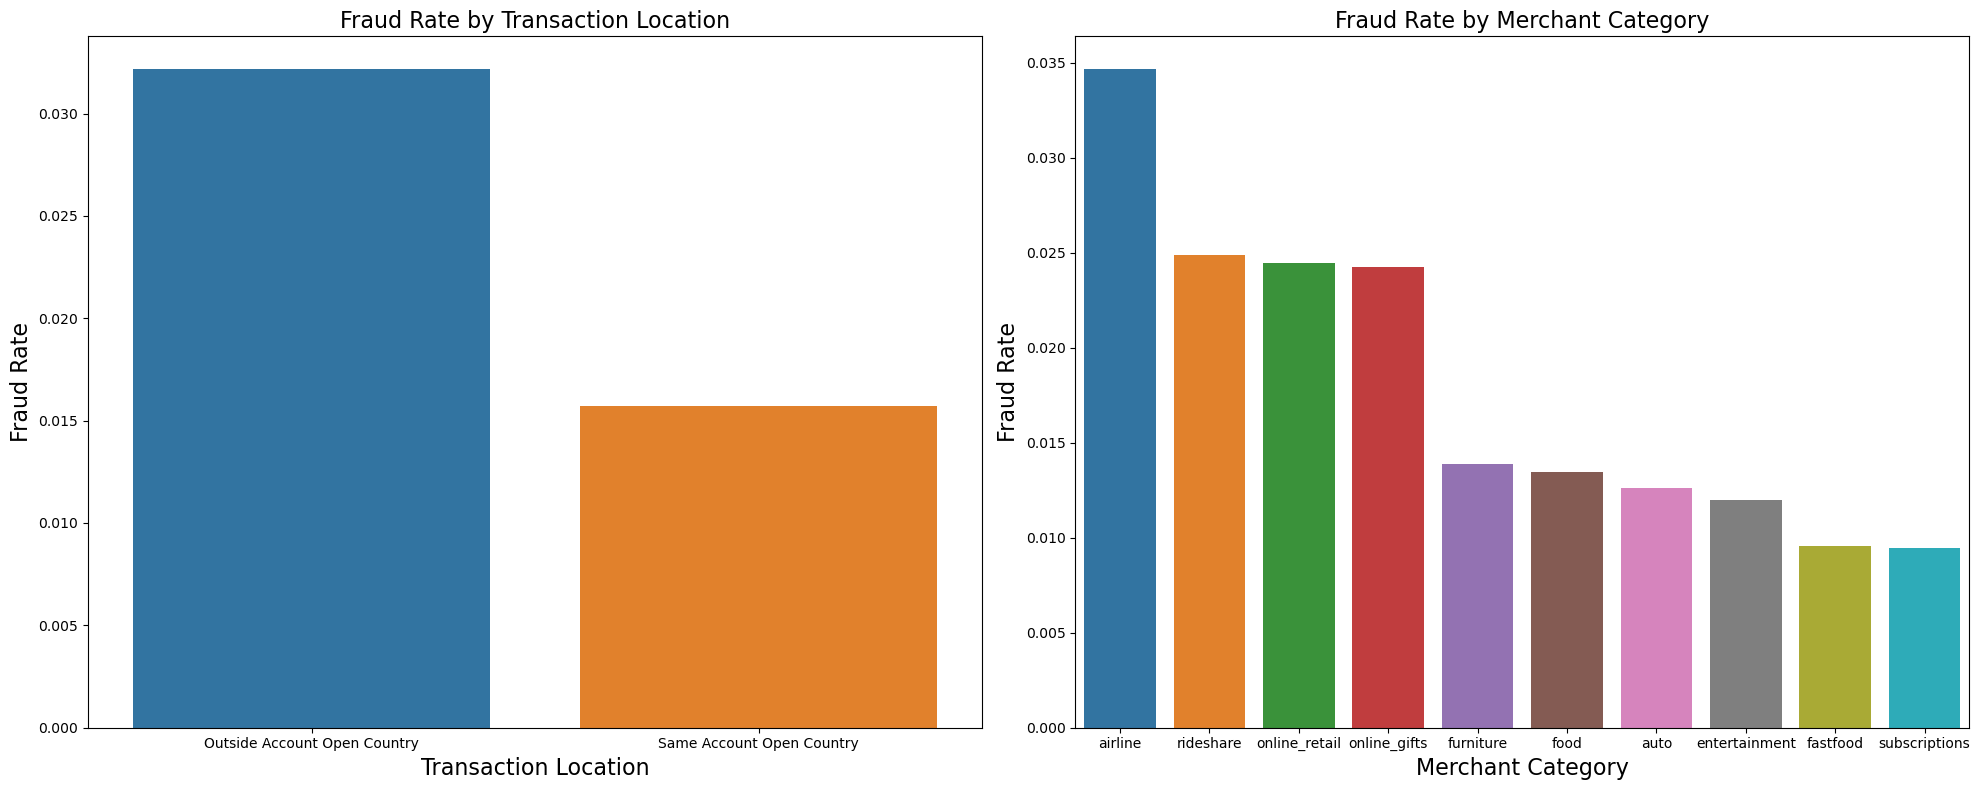

In [21]:
fig,axp = plt.subplots(1,2, figsize=[20,8])

# account country vs fraud
avg_fraud_country = df.groupby('OutsideAccountCountry')['isFraud'].mean().reset_index()
sns.barplot(x = 'OutsideAccountCountry', y = 'isFraud', data = avg_fraud_country,ax = axp[0])
axp[0].set_title('Fraud Rate by Transaction Location', fontsize = 16)
axp[0].set_xlabel('Transaction Location', fontsize = 16)
axp[0].set_ylabel('Fraud Rate', fontsize = 16)

# merchantCategoryCode vs fraud
avg_fraud_merchant = df.groupby('merchantCategory')['isFraud'].mean().reset_index()
avg_fraud_merchant = avg_fraud_merchant.sort_values('isFraud', ascending=False)
top_10_fraud_categories = avg_fraud_merchant.head(10)
sns.barplot(x = 'merchantCategory', y = 'isFraud', data = top_10_fraud_categories,ax = axp[1])
axp[1].set_title('Fraud Rate by Merchant Category', fontsize = 16)
axp[1].set_xlabel('Merchant Category', fontsize = 16)
axp[1].set_ylabel('Fraud Rate', fontsize = 16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

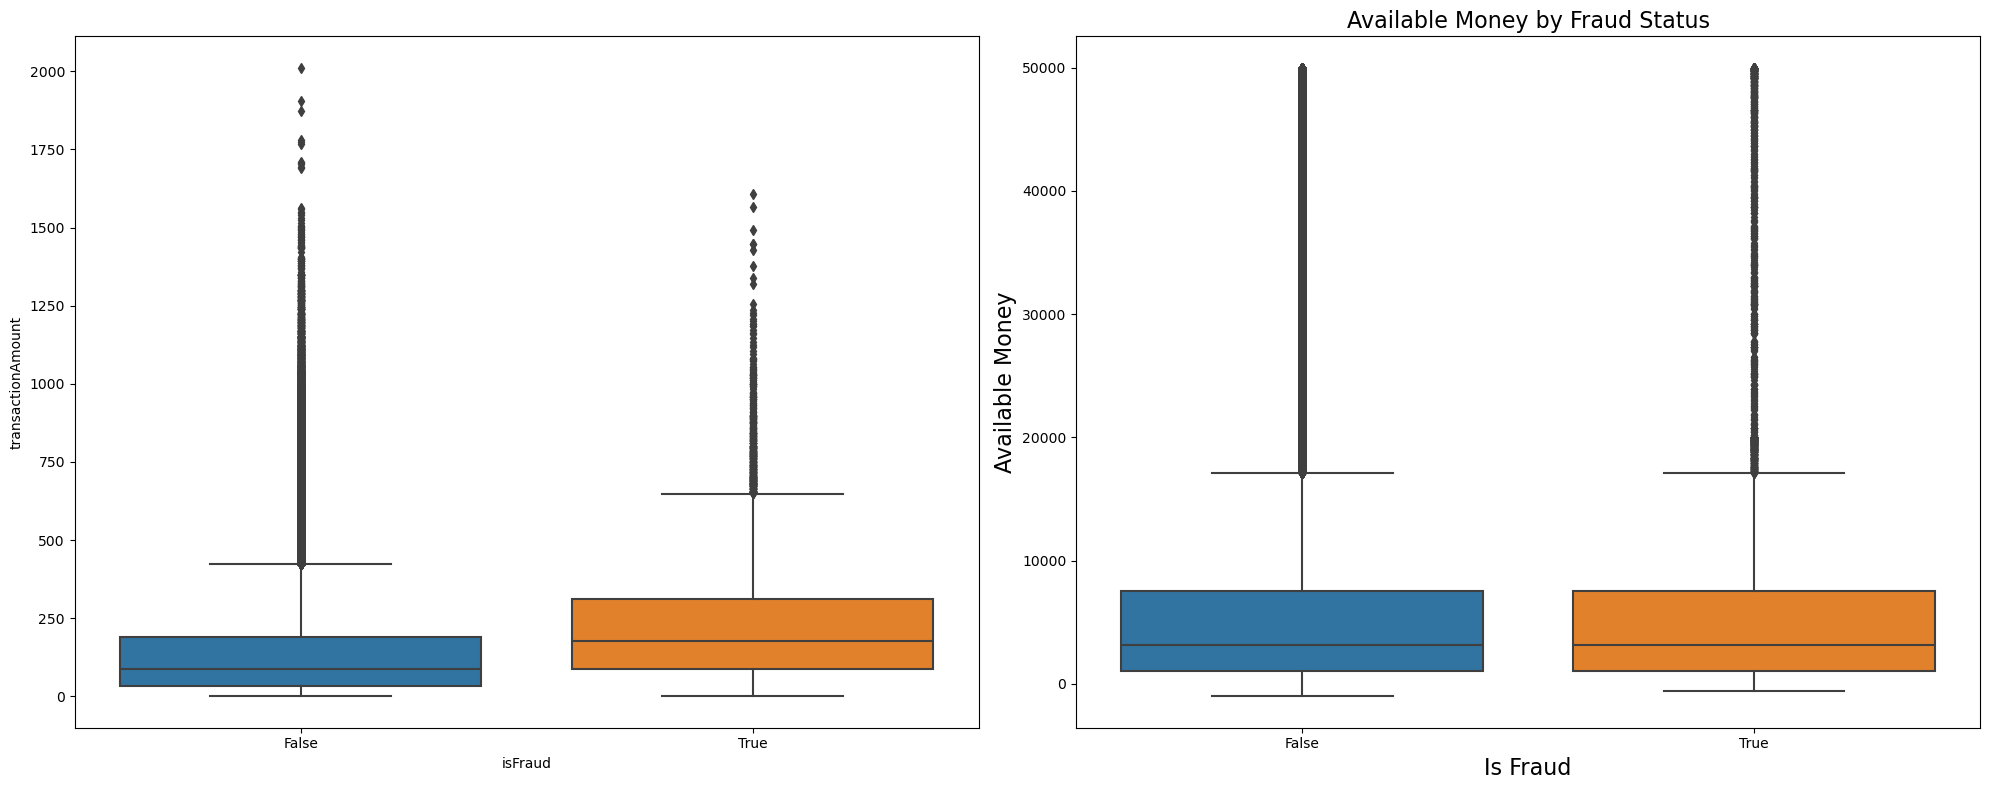

In [22]:
fig,axp = plt.subplots(1,2, figsize=[20,8])

# account open year vs fraud
sns.boxplot(x='isFraud', y='transactionAmount', data = df, ax = axp[0])
axp[1].set_title('Transaction Amount by Fraud Status', fontsize = 16)
axp[1].set_xlabel('Is Fraud', fontsize = 16)
axp[1].set_ylabel('Transaction Amount', fontsize = 16)

# Available Money vs fraud
sns.boxplot(x='isFraud', y='availableBalance', data = df, ax = axp[1])
axp[1].set_title('Available Money by Fraud Status', fontsize = 16)
axp[1].set_xlabel('Is Fraud', fontsize = 16)
axp[1].set_ylabel('Available Money', fontsize = 16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

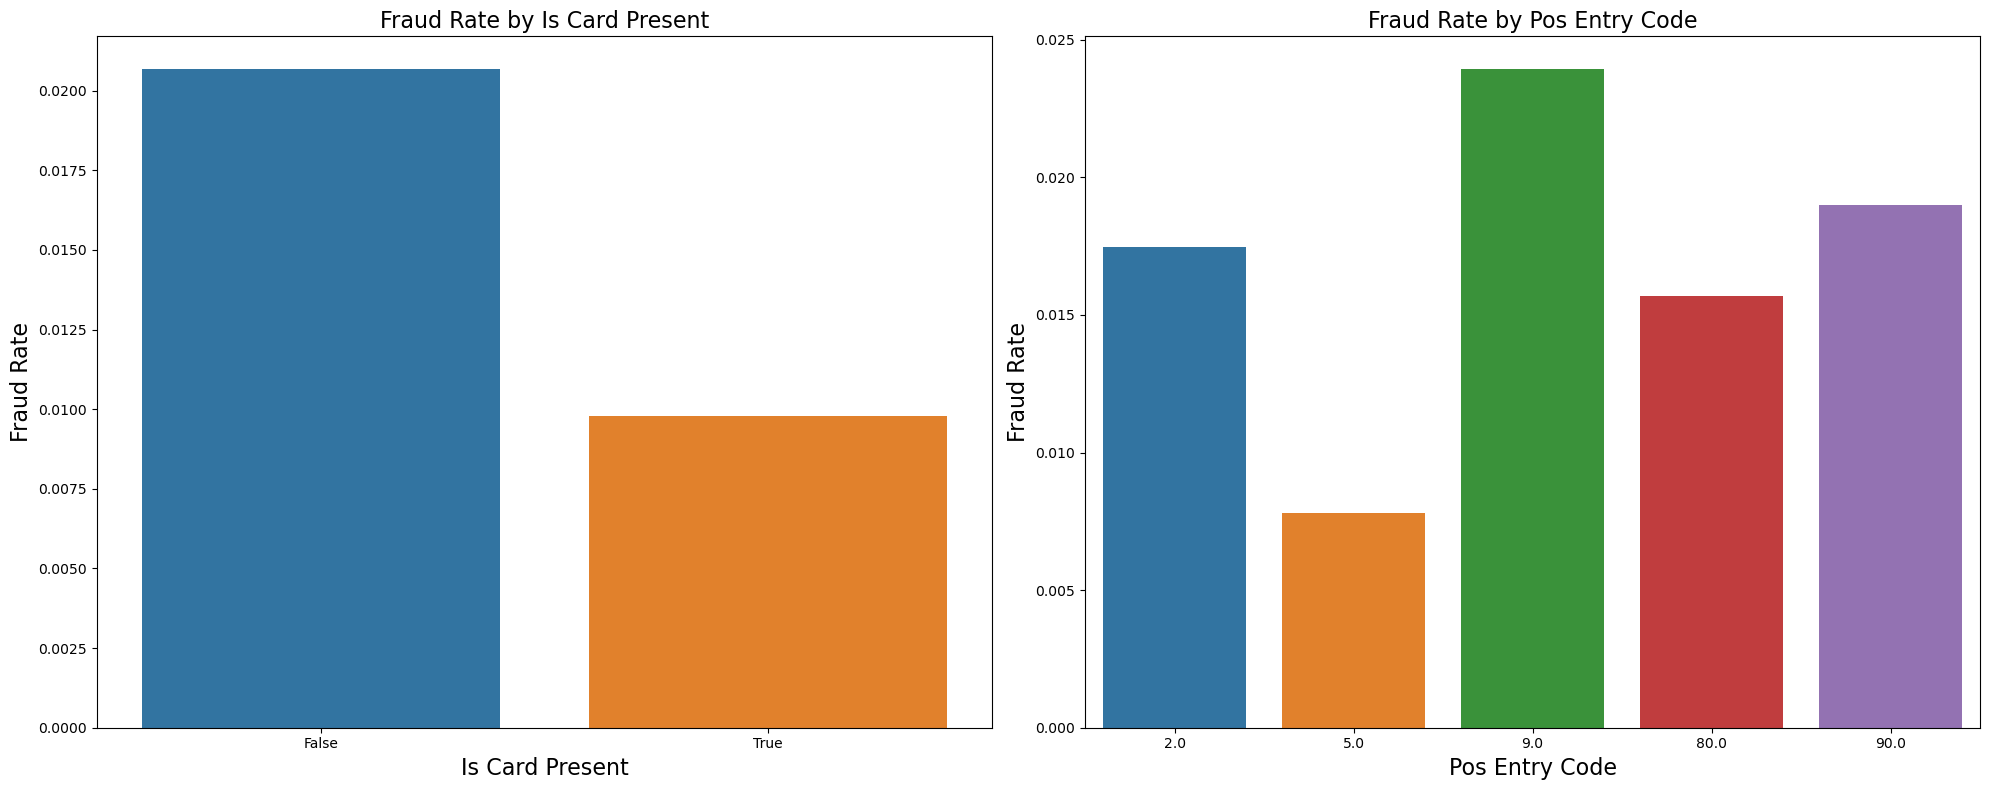

In [23]:
fig,axp = plt.subplots(1,2, figsize=[20,8])

# card present vs fraud
avg_fraud_present = df.groupby('cardPresent')['isFraud'].mean().reset_index()
sns.barplot(x = 'cardPresent', y = 'isFraud', data = avg_fraud_present,ax = axp[0])
axp[0].set_title('Fraud Rate by Is Card Present', fontsize = 16)
axp[0].set_xlabel('Is Card Present', fontsize = 16)
axp[0].set_ylabel('Fraud Rate', fontsize = 16)

# posConditionCode vs fraud
avg_fraud_type = df.groupby('posEntryMode')['isFraud'].mean().reset_index()
sns.barplot(x = 'posEntryMode', y = 'isFraud', data = avg_fraud_type,ax = axp[1])
axp[1].set_title('Fraud Rate by Pos Entry Code', fontsize = 16)
axp[1].set_xlabel('Pos Entry Code', fontsize = 16)
axp[1].set_ylabel('Fraud Rate', fontsize = 16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

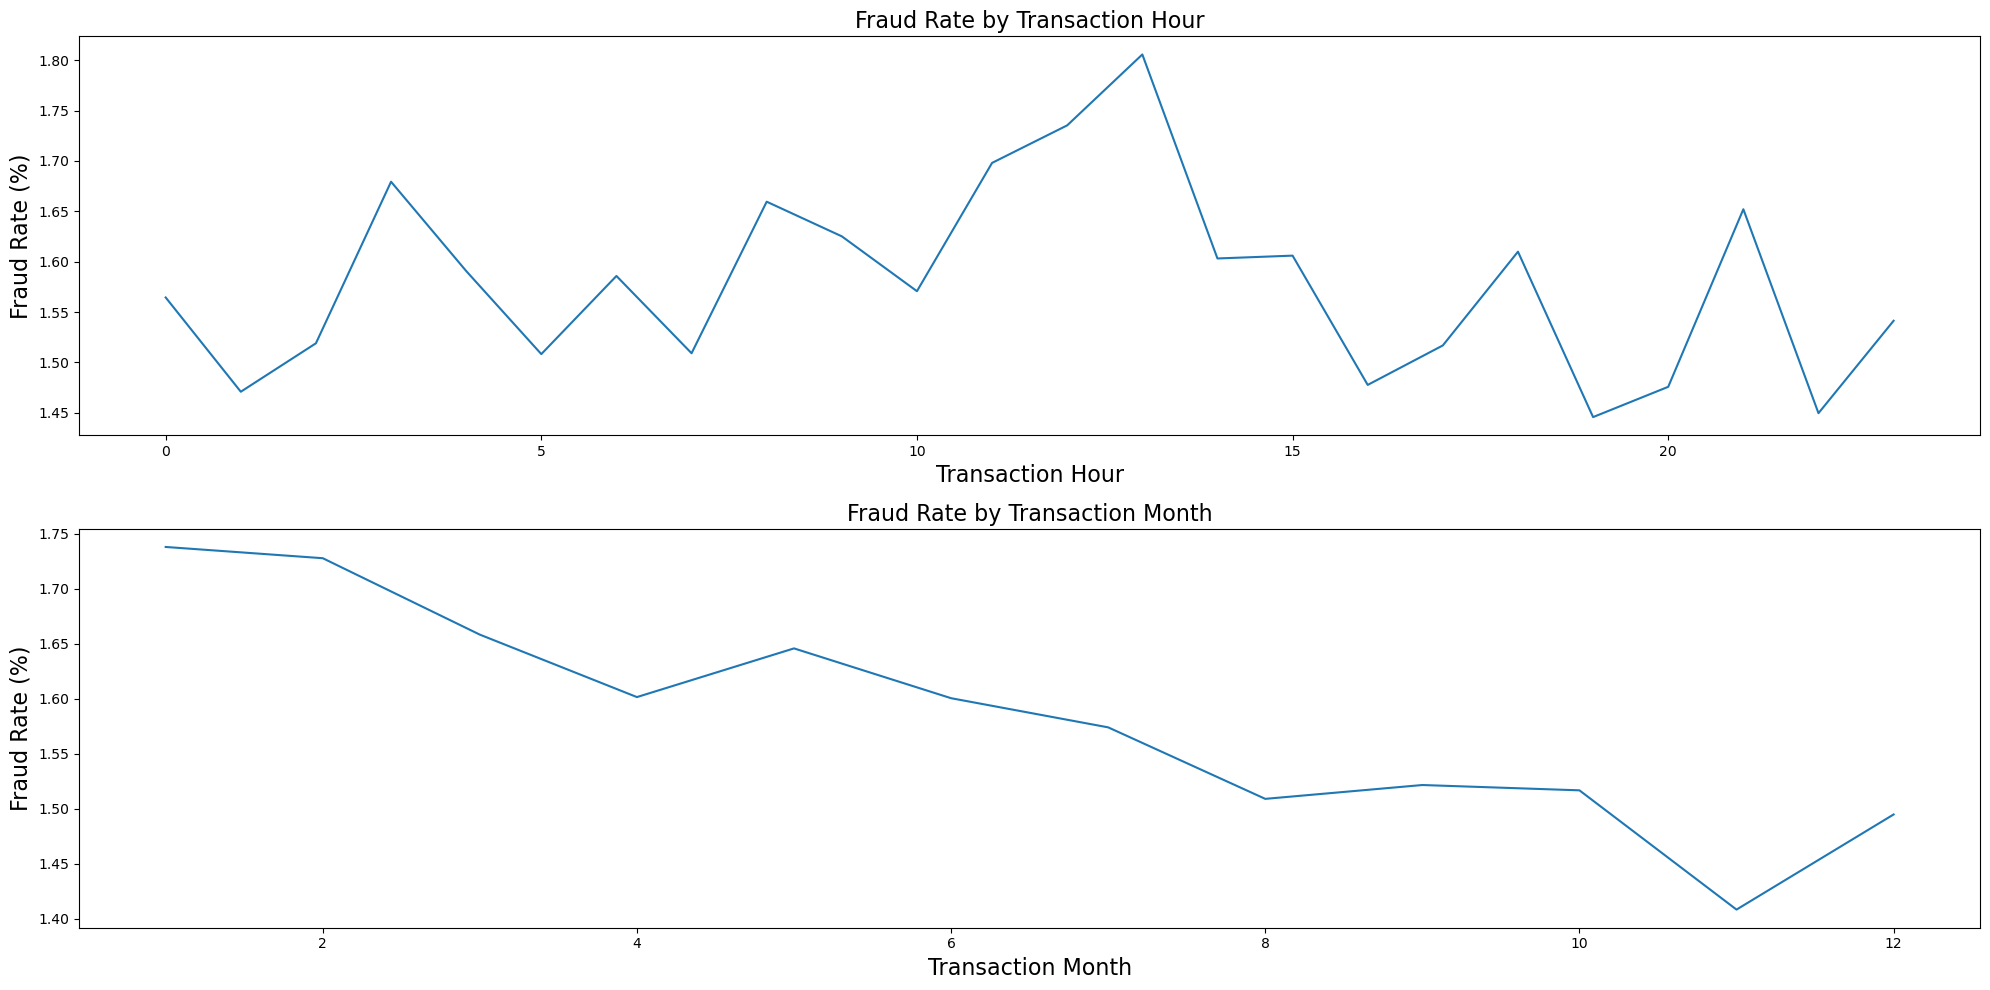

In [24]:
fig, axp = plt.subplots(2, 1, figsize=(20, 10))

# Fraud rate by hour
fraud_rate_by_hour = df.groupby('transactionHour')['isFraud'].mean() * 100
axp[0].plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values)
axp[0].set_xlabel('Transaction Hour', fontsize = 16)
axp[0].set_ylabel('Fraud Rate (%)', fontsize = 16)
axp[0].set_title('Fraud Rate by Transaction Hour', fontsize = 16)


# Fraud rate by month
fraud_rate_by_month = df.groupby('transactionMonth')['isFraud'].mean() * 100
axp[1].plot(fraud_rate_by_month.index, fraud_rate_by_month.values)
axp[1].set_xlabel('Transaction Month', fontsize = 16)
axp[1].set_ylabel('Fraud Rate (%)', fontsize = 16)
axp[1].set_title('Fraud Rate by Transaction Month', fontsize = 16)


plt.tight_layout()
plt.show()

#### User Transaction History

Users who committed fraudulent transactions had a higher frequency of transactions both annually and monthly.

In [25]:
df['ever_fraud'] = df.groupby(['accountNumber', 'customerId'])['isFraud'].transform('max')

In [26]:
df['month_fraud'] = df.groupby(['accountNumber', 'customerId','Year-Month'])['isFraud'].transform('max')

In [27]:
user_by_year = df[~df.duplicated(['accountNumber', 'customerId','ever_fraud'])]

In [28]:
month_by_year = df[~df.duplicated(['accountNumber', 'customerId','month_fraud'])]

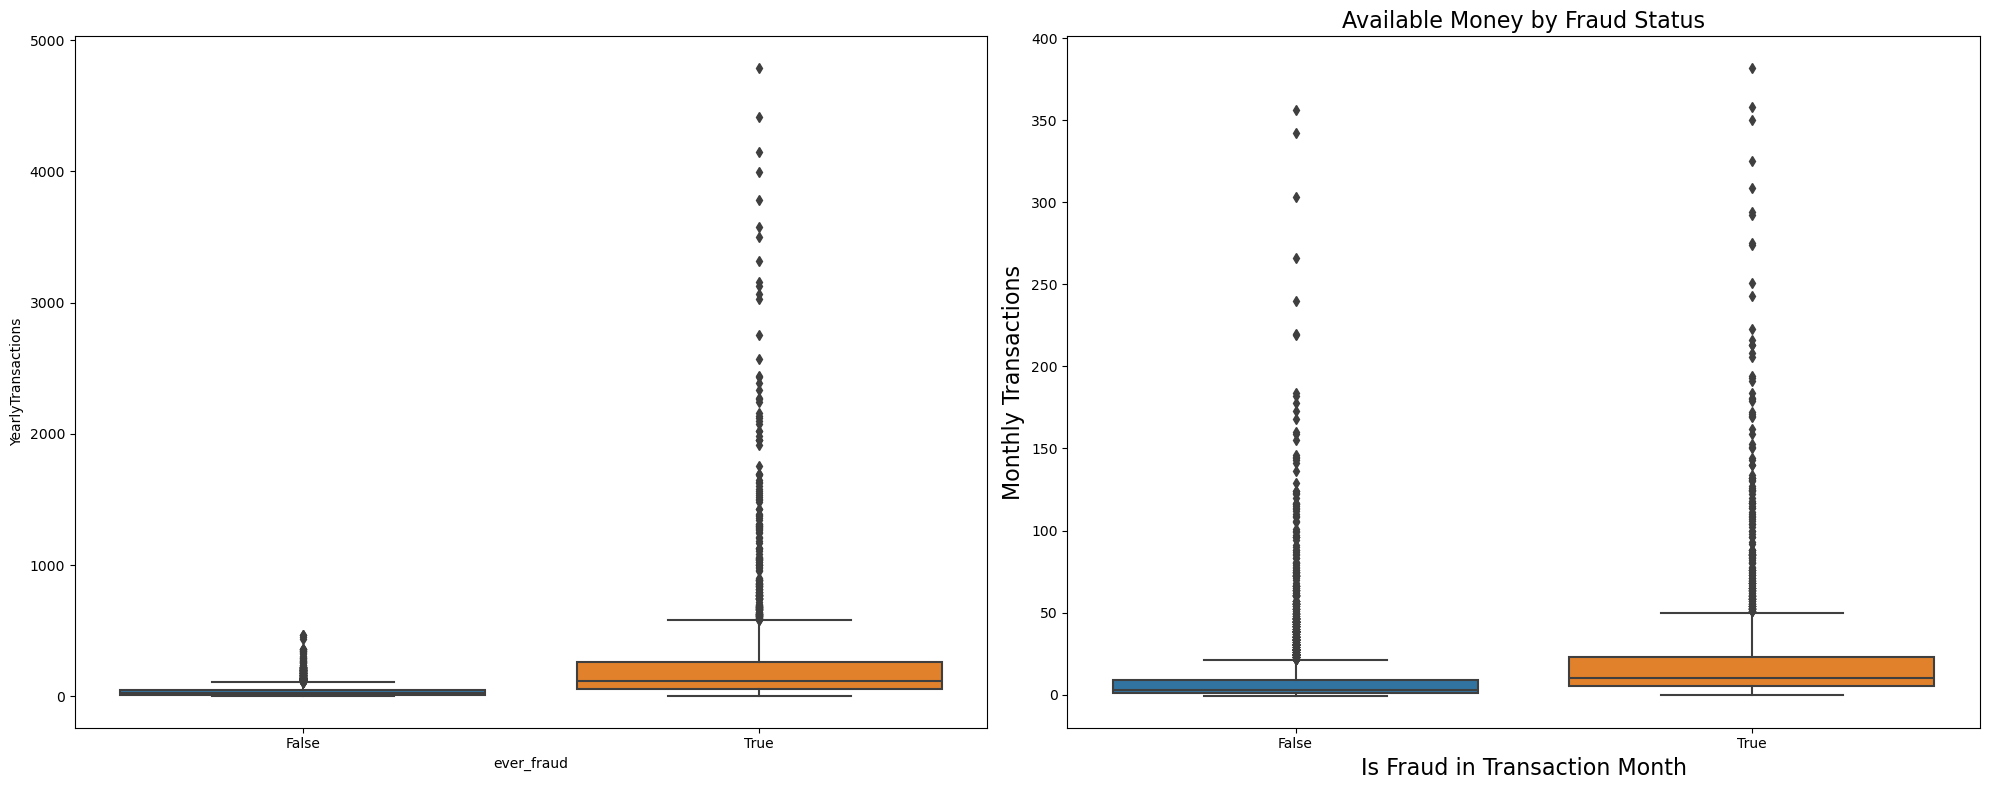

In [29]:
fig,axp = plt.subplots(1,2, figsize=[20,8])

# yearly transactions vs fraud
sns.boxplot(x='ever_fraud', y='YearlyTransactions', data = user_by_year[user_by_year['YearlyTransactions'] <= 5000], ax = axp[0])
axp[1].set_title('Transaction Amount by Yearly Transactions', fontsize = 16)
axp[1].set_xlabel('Is Ever Fraud', fontsize = 16)
axp[1].set_ylabel('Yearly Transactions', fontsize = 16)

# monthly transactions vs fraud
sns.boxplot(x = 'month_fraud', y = 'MonthlyTransactions', data = month_by_year[month_by_year['MonthlyTransactions'] <= 400], ax = axp[1])
axp[1].set_title('Available Money by Fraud Status', fontsize = 16)
axp[1].set_xlabel('Is Fraud in Transaction Month', fontsize = 16)
axp[1].set_ylabel('Monthly Transactions', fontsize = 16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Data Cleaning

In this session, we focused on missing data and outlier imputation.

#### Missing Values

For missing value imputation, we filled categorical features with 'unknown' and set missing values in the numeric feature MonthlyTransactions to 1.

In [30]:
df_copy = df.copy()

In [31]:
#drop unused columns
df.drop(['accountNumber','customerId','transactionTime','merchantCountry','cardExpiryDate','cardCvv','cvvEntered',
         'accountOpenDate', 'lastAddressChangeDate','cardLast4','Year-Month'], 
        axis=1, inplace=True)

For categorical values, we filled missing values with 'unknown'.For MonthlyTransactions, we filled missing values with 1.

In [32]:
df.isnull().sum()[df.isnull().sum() > 0]

acquiringCountry       4562
posEntryMode           4054
posConditionCode        409
transactionType         698
MonthlyTransactions       2
dtype: int64

In [33]:
columns_to_fill = ['acquiringCountry', 'posEntryMode', 'posConditionCode', 'transactionType']

for column in columns_to_fill:
    df[columns_to_fill] = df[columns_to_fill].fillna('unknown')

In [34]:
df['MonthlyTransactions'] = df['MonthlyTransactions'].fillna(1)

#### Outliers

8 features had outliers beyond 3 standard deviations. 

We observed more outliers in 'creditLimit' and 'availableBalance' due to ~7% users having exceptionally high credit limits, reaching up to $50k. These outliers likely reflect real financial behaviors rather than data errors.

User with high transaction amount might not nessacry had extreme high credit limits. We capped the outliers of 'transactionAmount' with 99 percentile.

The outlier of 'YearlyTransactions' and 'MonthlyTransactions' was from a single user who made 32850 transactions in a year. We capped the outliers of these variables with 95 percentile considering the transaction amount. 



In [35]:
numcol = ['creditLimit', 'availableBalance', 'transactionAmount', 'currentBalance','accountOpenYear',
          'yearOfLastAddressChange','transactionHour','transactionMonth','YearlyTransactions','MonthlyTransactions','currentExpYear']

In [36]:
#label outliers
outlier_results = {}  
outlier_index_df = pd.DataFrame()

for column in numcol:
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    # Create boolean series for outliers
    outlier_series = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    # Add to dataframe
    outlier_index_df[f'{column}_outlier'] = outlier_series

    # Store value counts in dictionary
    outlier_results[column] = sum(outlier_series)

In [37]:
outlier_results

{'creditLimit': 48781,
 'availableBalance': 25524,
 'transactionAmount': 14933,
 'currentBalance': 18183,
 'accountOpenYear': 11628,
 'yearOfLastAddressChange': 19475,
 'transactionHour': 0,
 'transactionMonth': 0,
 'YearlyTransactions': 32850,
 'MonthlyTransactions': 32850,
 'currentExpYear': 0}

In [38]:
outlier_index_df.head()

,creditLimit_outlier,availableBalance_outlier,transactionAmount_outlier,currentBalance_outlier,accountOpenYear_outlier,yearOfLastAddressChange_outlier,transactionHour_outlier,transactionMonth_outlier,YearlyTransactions_outlier,MonthlyTransactions_outlier,currentExpYear_outlier
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False


#### Credit Limit & Available Money

In [39]:
df['creditLimit'][outlier_index_df['creditLimit_outlier']].describe()

count    48781.0
mean     50000.0
std          0.0
min      50000.0
25%      50000.0
50%      50000.0
75%      50000.0
max      50000.0
Name: creditLimit, dtype: float64

In [40]:
np.percentile(df['creditLimit'], 93),np.percentile(df['creditLimit'], 94)

(20000.0, 50000.0)

In [41]:
df['availableBalance'][outlier_index_df['availableBalance_outlier']].describe()

count    25524.000000
mean     44808.771993
std       5013.621813
min      32894.460000
25%      41312.055000
50%      46653.965000
75%      49112.680000
max      50000.000000
Name: availableBalance, dtype: float64

#### Transaction Amount

In [42]:
df['transactionAmount'][outlier_index_df['transactionAmount_outlier']].describe()

count    14933.000000
mean       730.317105
std        151.118339
min        580.170000
25%        622.840000
50%        683.350000
75%        785.220000
max       2011.540000
Name: transactionAmount, dtype: float64

In [43]:
df['creditLimit'][outlier_index_df['transactionAmount_outlier']].describe()

count    14933.000000
mean     11032.009643
std      11920.077461
min        250.000000
25%       5000.000000
50%       7500.000000
75%      15000.000000
max      50000.000000
Name: creditLimit, dtype: float64

In [44]:
df['transactionAmount'][outlier_index_df['transactionAmount_outlier']] =  df['transactionAmount'].quantile(0.99)

/var/folders/8_/6kwdhd_569jdkx_y3z0bylbs18tbjp/T/ipykernel_69023/1779077754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactionAmount'][outlier_index_df['transactionAmount_outlier']] =  df['transactionAmount'].quantile(0.99)


In [45]:
df['transactionAmount'].describe()

count    786363.000000
mean        135.947293
std         142.170912
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max         675.630400
Name: transactionAmount, dtype: float64

#### Transaction Counts

In [46]:
df['YearlyTransactions'][outlier_index_df['YearlyTransactions_outlier']].describe()

count    32850.0
mean     30058.0
std          0.0
min      30058.0
25%      30058.0
50%      30058.0
75%      30058.0
max      30058.0
Name: YearlyTransactions, dtype: float64

In [47]:
df['creditLimit'][outlier_index_df['YearlyTransactions_outlier']].describe()

count    32850.0
mean      5000.0
std          0.0
min       5000.0
25%       5000.0
50%       5000.0
75%       5000.0
max       5000.0
Name: creditLimit, dtype: float64

In [48]:
df_copy['accountNumber'][outlier_index_df['YearlyTransactions_outlier']].unique()

array([380680241])

In [49]:
df['MonthlyTransactions'][outlier_index_df['MonthlyTransactions_outlier']].describe()

count    32850.000000
mean      2505.929802
std         62.794280
min       2408.000000
25%       2450.000000
50%       2513.000000
75%       2549.000000
max       2624.000000
Name: MonthlyTransactions, dtype: float64

In [50]:
df['creditLimit'][outlier_index_df['MonthlyTransactions_outlier']].describe()

count    32850.0
mean      5000.0
std          0.0
min       5000.0
25%       5000.0
50%       5000.0
75%       5000.0
max       5000.0
Name: creditLimit, dtype: float64

In [51]:
df_copy['accountNumber'][outlier_index_df['MonthlyTransactions_outlier']].unique()

array([380680241])

In [52]:
df['YearlyTransactions'][outlier_index_df['YearlyTransactions_outlier']] = df['YearlyTransactions'].quantile(0.95)

/var/folders/8_/6kwdhd_569jdkx_y3z0bylbs18tbjp/T/ipykernel_69023/3019466916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YearlyTransactions'][outlier_index_df['YearlyTransactions_outlier']] = df['YearlyTransactions'].quantile(0.95)


In [53]:
df['MonthlyTransactions'][outlier_index_df['MonthlyTransactions_outlier']] = df['MonthlyTransactions'].quantile(0.95)

/var/folders/8_/6kwdhd_569jdkx_y3z0bylbs18tbjp/T/ipykernel_69023/2284231710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MonthlyTransactions'][outlier_index_df['MonthlyTransactions_outlier']] = df['MonthlyTransactions'].quantile(0.95)


### Correlation Analysis

All the features were not independent to isFraud. availableBalance and currentBalance were highly correalted with creditLimit due to their mathmetic relationship.

In [68]:
from scipy.stats import chi2_contingency

In [55]:
# numeric features vs isfraud

for col in numcol:
    crosstab = pd.crosstab(df['isFraud'], pd.cut(df[col], 6))
    chi2, p, dof, expected = chi2_contingency(crosstab)
    if p < 0.05:
        print(f"isFraud and {col} are correlated (p = {p:.4f})")

isFraud and creditLimit are correlated (p = 0.0000)
isFraud and availableBalance are correlated (p = 0.0199)
isFraud and transactionAmount are correlated (p = 0.0000)
isFraud and currentBalance are correlated (p = 0.0000)
isFraud and accountOpenYear are correlated (p = 0.0000)
isFraud and yearOfLastAddressChange are correlated (p = 0.0000)
isFraud and transactionHour are correlated (p = 0.0014)
isFraud and transactionMonth are correlated (p = 0.0000)
isFraud and YearlyTransactions are correlated (p = 0.0000)
isFraud and MonthlyTransactions are correlated (p = 0.0000)


In [56]:
# categorical features vs isfraud
catcol = ['merchantName','acquiringCountry','posEntryMode','posConditionCode','merchantCategory','isTypo',
          'transactionType','cardPresent','expiryKeyMatch','OutsideAccountCountry']

for col in catcol:
    crosstab = pd.crosstab(df[col], df['isFraud'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    if p < 0.05:
        print(f"{col} and isFraud are correlated (p = {p:.4f})")

merchantName and isFraud are correlated (p = 0.0000)
acquiringCountry and isFraud are correlated (p = 0.0000)
posEntryMode and isFraud are correlated (p = 0.0000)
posConditionCode and isFraud are correlated (p = 0.0000)
merchantCategory and isFraud are correlated (p = 0.0000)
isTypo and isFraud are correlated (p = 0.0000)
transactionType and isFraud are correlated (p = 0.0000)
cardPresent and isFraud are correlated (p = 0.0000)
OutsideAccountCountry and isFraud are correlated (p = 0.0000)


In [57]:
pd.set_option('display.precision', 4)
corr = df[numcol].corr()

[Text(0.5, 0, 'creditLimit'),
 Text(1.5, 0, 'availableBalance'),
 Text(2.5, 0, 'transactionAmount'),
 Text(3.5, 0, 'currentBalance'),
 Text(4.5, 0, 'accountOpenYear'),
 Text(5.5, 0, 'yearOfLastAddressChange'),
 Text(6.5, 0, 'transactionHour'),
 Text(7.5, 0, 'transactionMonth'),
 Text(8.5, 0, 'YearlyTransactions'),
 Text(9.5, 0, 'MonthlyTransactions'),
 Text(10.5, 0, 'currentExpYear')]

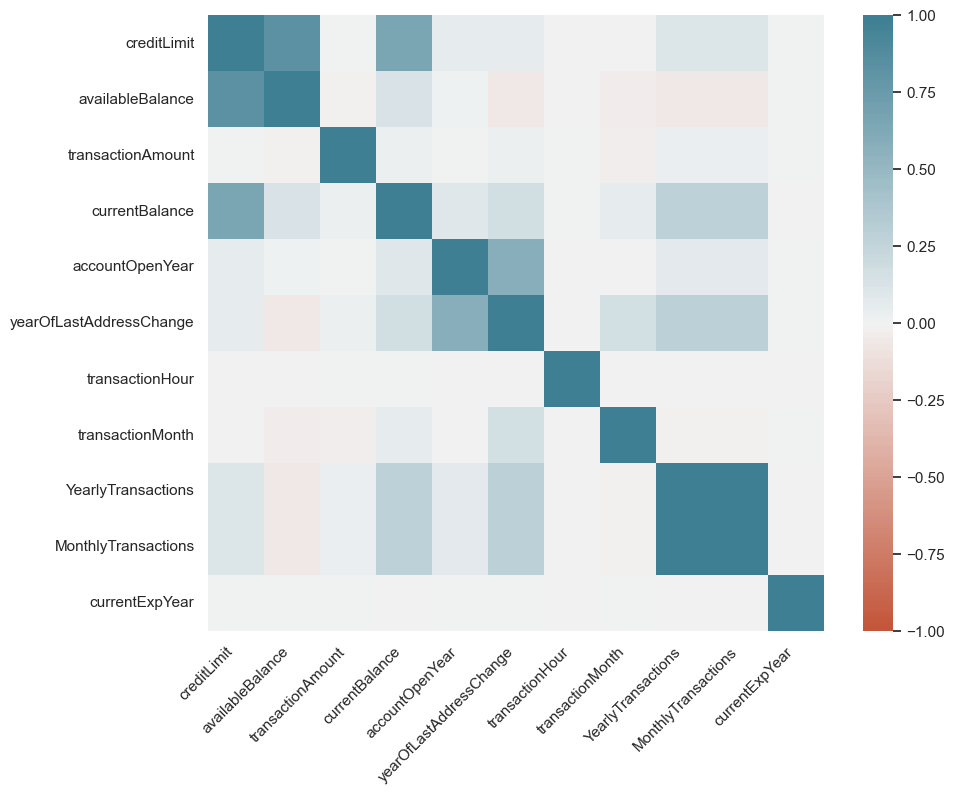

In [58]:
sns.set()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

### Feature Enigineer

In [59]:
# recode merchant category
def recode_merchant_category(val):
    if val in ['online_retail','online_gifts']:
        return 'online_shopping'
    
    elif val in ['fastfood','food','food_delivery']:
        return 'food'
    
    elif val in ['subscriptions','online_subscriptions']:
        return 'subscriptions'
    
    elif val in ['entertainment','rideshare','hotels']:
        return val
    else:
        return 'others'



In [60]:
df['merchantCategory']= df['merchantCategory'].apply(recode_merchant_category)

In [61]:
#one-hot encoding
df_encoded = pd.get_dummies(df,columns = ['acquiringCountry','posEntryMode','posConditionCode','merchantCategory','isTypo',
          'transactionType','OutsideAccountCountry'], dtype=int)

In [62]:
df_encoded['cardPresent'] = df_encoded['cardPresent'].astype(int)
df_encoded['expiryKeyMatch'] = df_encoded['expiryKeyMatch'].astype(int)
df_encoded['isFraud'] = df_encoded['isFraud'].astype(int)

### Trian Test Split

We split the data into training and test sets for modeling. MerchantName was encoded based on its occurrence separately in each set, normalized by sample size to mitigate sample size influence.

In [63]:
df_encoded.drop(['ever_fraud','month_fraud'],axis = 1,inplace = True)

In [64]:
y = df_encoded['isFraud']
X = df_encoded.drop(['isFraud'], axis=1)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [65]:
# encoding merchantName
X_train_merchant_mapping = X_train['merchantName'].value_counts(dropna=False) 
X_train['merchantCounts'] =  X_train['merchantName'].map(X_train_merchant_mapping)

X_test_merchant_mapping = X_test['merchantName'].value_counts(dropna=False) 
X_test['merchantCounts'] =  X_test['merchantName'].map(X_test_merchant_mapping)

In [66]:
X_train['merchantCounts'] = X_train['merchantCounts']/X_train.shape[0]
X_test['merchantCounts'] = X_test['merchantCounts']/X_test.shape[0]

In [67]:
X_train.drop(['merchantName'],axis = 1,inplace = True)
X_test.drop(['merchantName'],axis = 1,inplace = True)

### Model Fitting

Since we retained outliers for 'creditLimit' and 'availableMoney', we opted for tree-based models(Random Forest, Xgboost and Isolation Forest) to predict whether a transaction was fraudulent, as these models are inherently less sensitive to extreme values and can effectively handle the skewed distributions often present in financial data. 

We chose recall as the evaluation metric because the model should identify as many actual fraud cases as possible.  as the cost of missing a fraudulent transaction is typically much higher than the cost of investigating a legitimate one flagged by the model. 

The Random Forest model outperformed the other 2 models, achieving the highest recall and demonstrating efficient model fitting. It correctly identified 75% of legitimate and 68% of fraund transactions.

#### Random Forest

In [69]:
# Random Forest
classifier_RF = RandomForestClassifier(max_features= 'sqrt',class_weight = 'balanced')
param_grid_RF = {'n_estimators': [  100, 200 ],'max_depth': [ 7, 8, 9] }
grid_search_RF = GridSearchCV(classifier_RF, param_grid_RF, cv=5, scoring='recall', n_jobs=-1)
grid_search_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9], 'n_estimators': [100, 200]},
             scoring='recall')

In [70]:
prediction_RF = grid_search_RF.predict(X_test)
print(classification_report(y_test,prediction_RF))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85    154841
           1       0.04      0.68      0.08      2432

    accuracy                           0.75    157273
   macro avg       0.52      0.71      0.47    157273
weighted avg       0.98      0.75      0.84    157273



In [71]:
# RF with smote
smote = SMOTE(sampling_strategy = 1/3,random_state=12)
x_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
unique, counts = np.unique(y_train_sm, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 619105]
 [     1 206368]]


In [72]:
param_grid_RF_sm = {'n_estimators': [100, 200 ],'max_depth': [ 7, 8, 9], 'max_features': ['sqrt']}
grid_search_RF_sm = GridSearchCV(classifier_RF, param_grid_RF_sm, cv=5, scoring='recall', n_jobs=-1)
grid_search_RF_sm.fit(x_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9], 'max_features': ['sqrt'],
                         'n_estimators': [100, 200]},
             scoring='recall')

In [73]:
prediction_RF_sm = grid_search_RF_sm.predict(X_test)
print(classification_report(y_test,prediction_RF_sm))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93    154841
           1       0.05      0.38      0.09      2432

    accuracy                           0.88    157273
   macro avg       0.52      0.63      0.51    157273
weighted avg       0.97      0.88      0.92    157273



#### Xgboost

In [74]:
from xgboost import XGBClassifier
from sklearn.utils import class_weight

param_grid_XGB = {
    'max_depth': [7,8,9],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'subsample': [0.5,0.8]
}

# Calculate class weights for unbalanced data
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

xgb_model = XGBClassifier(objective='binary:logistic', scale_pos_weight=class_weights[1], random_state=42)

# Perform GridSearchCV
grid_search_XGB = GridSearchCV(estimator = xgb_model, param_grid = param_grid_XGB, cv = 5, scoring = 'recall', n_jobs=-1)
grid_search_XGB.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [7, 8, 9],
                         'n_estimators': [100, 200], 'subsample': [0.5, 0.8]},
             scoring='recall')

In [75]:
prediction_XGB = grid_search_XGB.predict(X_test)
print(classification_report(y_test,prediction_XGB))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95    154841
           1       0.07      0.44      0.12      2432

    accuracy                           0.90    157273
   macro avg       0.53      0.67      0.53    157273
weighted avg       0.98      0.90      0.93    157273



In [76]:

xgb_model_sm = XGBClassifier(objective='binary:logistic', random_state=42)

# Perform GridSearchCV
grid_search_XGB_sm = GridSearchCV(estimator = xgb_model_sm, param_grid = param_grid_XGB, cv = 5, scoring = 'recall', n_jobs=-1)
grid_search_XGB_sm.fit(x_train_sm, y_train_sm)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [7, 8, 9],
                         'n_estimators': [100, 200], 'subsample': [0.5, 0.8]},
             scoring='recall')

In [77]:
prediction_XGB_sm = grid_search_XGB_sm.predict(X_test)
print(classification_report(y_test,prediction_XGB_sm))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    154841
           1       0.06      0.18      0.09      2432

    accuracy                           0.94    157273
   macro avg       0.52      0.56      0.53    157273
weighted avg       0.97      0.94      0.96    157273



#### Isolation Forest

In [78]:

kf = KFold(n_splits= 5, shuffle = True, random_state = 42)

param_grid = {
    
    'n_estimators': [100, 200],  
    'max_samples': ['auto', 0.5, 0.8], 
    'max_features': [0.5, 0.65,0.8]
}

best_recall = -1
best_params = {}

for n_estimators in param_grid['n_estimators']:
    for max_samples in param_grid['max_samples']:
        for max_features in param_grid['max_features']:
            current_recall = 0

            for train_index, test_index in kf.split(X_train):
                X_train_CV, X_test_CV = X_train.iloc[train_index], X_train.iloc[test_index]
                y_train_CV, y_test_CV = y_train.iloc[train_index], y_train.iloc[test_index]

                model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, contamination='auto', random_state=42)
                model.fit(X_train)
        
                # Predict anomaly scores
                y_pred_scores = model.decision_function(X_test)

                # Assuming a threshold of 0 (you might need to adjust this)
                y_pred = [1 if score < 0 else 0 for score in y_pred_scores]

                current_recall += recall_score(y_test, y_pred)

        average_recall = current_recall / 5

        if average_recall > best_recall:
            best_recall = average_recall
            best_params = {
                'n_estimators': n_estimators,
                'max_samples': max_samples,
                'max_features': max_features
            }

print(f"Best hyperparameters: {best_params}, Best recall: {best_recall}")

Best hyperparameters: {'n_estimators': 100, 'max_samples': 'auto', 'max_features': 0.8}, Best recall: 0.08018092105263158


### Feature Importance

Features such as 'transactionAmount', 'OutsideAccountCountry', and 'posEntryMode' are critical in identifying fraudulent transactions. Based on data exploration, transactions with large amounts, those occurring outside the account holder's home country, or those using POS entry mode '02' were found to be significantly more susceptible to fraud. These patterns highlight the importance of monitoring high-value transactions, cross-border activities, and specific POS entry methods to enhance fraud detection efforts.

In [79]:
# Concatenating X_train and X_test
X_all = pd.concat([X_train, X_test], axis=0)

# Concatenating y_train and y_test
y_all = pd.concat([y_train, y_test], axis=0)

In [80]:
# check feature importance of Random Forest
forest_best = RandomForestClassifier(class_weight='balanced', max_depth = 7, n_estimators = 200)
forest_best.fit(X_all, y_all)

importances = forest_best.feature_importances_

indices = np.argsort(importances)[::-1]


In [81]:
# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(10):
    print ("{0} : {1}".format(X.columns[indices[ind]],round(importances[indices[ind]], 2)))

Feature importance ranking by Random Forest Model:
transactionAmount : 0.24
OutsideAccountCountry_Same Account Open Country : 0.16
posEntryMode_2.0 : 0.15
merchantCategory_hotels : 0.06
currentBalance : 0.05
posEntryMode_5.0 : 0.05
currentExpYear : 0.05
YearlyTransactions : 0.04
merchantCategory_online_shopping : 0.02
creditLimit : 0.02


# Summary

This project aimed to predict fraudulent transactions in order to improve the company’s risk management and profitability. Through exploratory data analysis, we observed that transactions originating from the U.S. or occurring in the same country where the card was issued were associated with a lower risk of fraud. In contrast, fraudulent transactions tended to involve higher amounts, occurred more frequently between 11 a.m. and 1 p.m., and were often found in common categories such as airlines, rideshares, and online purchases.

Eight features exhibited outliers beyond three standard deviations. We retained the values for creditLimit and availableBalance, as these likely reflected legitimate financial behaviors rather than data entry errors. For transactionAmount, we capped values at the 99th percentile since unusually high amounts were not supported by correspondingly high credit limits, suggesting possible data anomalies. Additionally, we capped YearlyTransactions and MonthlyTransactions at the 95th percentile due to a single user making 32,850 transactions in one year, which skewed the distribution.

We tested three models—Random Forest, XGBoost, and Isolation Forest—for fraud prediction. The Random Forest model outperformed the others, correctly identifying 75% of non-fraudulent transactions and 68% of fraudulent ones. The most important features contributing to fraud detection included transaction amount, whether the transaction occurred in the same country as the card’s issuing country, interest rate, and POS entry mode.

# Recommendations

Although we are excited by these findings, there is still significant work to be done to better
understand user spending behavior and enhance fraud prevention strategies. One potential direction
for future work is to combining the two classification models in an ensemble approach to improve
fraud detection. We can also try to integrate graph-based features, capturing relationships between
amounts, merchants, and transactions into the existing model to enrich the model’s predictive power.
Additionally, combining classification models with unsupervised methods, such as Isolation Forest,
could help detect novel fraud patterns at customer level and global level that traditional supervised
approaches might miss.
Further steps include deploying the model in a real-time environment by converting it into an
API-based system for real-time transaction scoring. Additionally, if more relevant data becomes
available, the model can be extended to detect fraud across multiple channels, including mobile
banking and ATM withdrawals, providing a more comprehensive fraud detection framework